In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

2022-12-06 10:07:24.190706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 10:07:24.566319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/linuxbrew/.linuxbrew/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-06 10:07:24.566341: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-06 10:07:24.613077: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has a

In [3]:
# test = True
test = False

The Brain tumor dataset is taken from `./brain_tumor_dataset/yes` and `brain_tumor_dataset/no` directories. 
> **Dataset Source:** https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection 
> 
> **Dataset Description**: The dataset contains 2 folders (yes/no) and each folder contains subfolders with several images. There are 253 images with brain tumor and 98 images without brain tumor. The images are in .jpg format. The image sizes are not consistent.

In [4]:
yes_imgs = os.listdir('./brain_tumor_dataset/yes')
no_imgs = os.listdir('./brain_tumor_dataset/no')

full_dataset = np.concatenate([yes_imgs, no_imgs])


In [5]:
if (test):
    print(full_dataset.size, full_dataset)


The `resized_imgs` list contains the resized images of the `yes_imgs` and `no_imgs` lists.


In [6]:
orig_imgs: list[cv2.Mat] = []
resized_imgs: list[cv2.Mat] = []
for img_file in yes_imgs:
    img = cv2.imread('./brain_tumor_dataset/yes/'+img_file)
    orig_imgs.append(img)
    resized_img = cv2.resize(img, (32, 32))
    resized_imgs.append(resized_img)

for img_file in no_imgs:
    img = cv2.imread('./brain_tumor_dataset/no/'+img_file)
    orig_imgs.append(img)
    resized_img = cv2.resize(img, (32, 32))
    resized_imgs.append(resized_img)

In [7]:
# Displaying the first image in resized_imgs
if (test):
    cv2.imshow('image0', resized_imgs[0])
    cv2.waitKey(0)
    cv2.destroyAllWindows()


Convert the `resized_imgs` list to a numpy array and save it as `X`.


In [8]:
X = np.squeeze(resized_imgs)

In [9]:
if (test):
    print(type(X))
    print(X.shape)
    print(X)


In [10]:
if (test):
    print(resized_imgs)


Normalize each pixel of the image present in the numpy array `X` and save it as `X`.


In [11]:

# normalize data
X = X.astype('float32')
X /= 255

In [12]:
if (test):
    print(X)


The `img_labels` list stores the labels for each image. The labels are 0 for "no" and 1 for "yes".


In [13]:
labels_yes = np.full(len(yes_imgs), 1)
labels_no = np.full(len(no_imgs), 0)

img_labels = np.concatenate([labels_yes, labels_no])


In [14]:
if (test):
    print(img_labels.size, img_labels)


Prepare `x_train` and `x_valid` from the `X` image data list.
Prepare `y_train` and `y_valid` from the `img_labels` list.

As stated above, the dataset is divided into 2 directories: "yes" & "no". There are 253 images (155 images for "yes" and 98 images for "no"). We were storing the labels for each image in the `img_labels` list. The labels are 0 for "no" and 1 for "yes".

So we are separately storing the images of "yes" and "no" in the `yes_imgs` and `no_imgs` lists respectively and thier labels in the `yes_labels` and `no_labels` lists respectively.

We will divide those images into training and validation sets. We will use 80% of the images for training and 20% of the images for validation. So we will use 202 images for training and 51 images for validation. Out of 202 images, 124 images are of "yes" and 78 images are of "no". Similarly, out of 51 images, 31 images are of "yes" and 20 images are of "no".


In [51]:
# Splitting the dataset into the Training set (i.e `x_train`) and Testing set/Validation set (i.e `x_valid`)
# We will also keep the original images of the validation set in `x_orig_valid` for visualization purposes
yes_imgs = X[:155]
no_imgs = X[155:]
yes_orig_imgs = orig_imgs[:155]
no_orig_imgs = orig_imgs[155:]

x_yes_train = yes_imgs[:124]
x_yes_valid = yes_imgs[124:]
x_yes_orig_valid = yes_orig_imgs[124:]

x_no_train = no_imgs[:78]
x_no_valid = no_imgs[78:]
x_no_orig_valid = no_orig_imgs[78:]

x_train = np.concatenate([x_yes_train, x_no_train])
x_valid = np.concatenate([x_yes_valid, x_no_valid])
x_orig_valid = np.concatenate([x_yes_orig_valid, x_no_orig_valid])

# Splitting the dataset labels for the Training set (i.e `y_train`) and Testing set/Validation set (i.e `y_valid`)
yes_labels = img_labels[:155]
no_labels = img_labels[155:]

y_yes_train = yes_labels[:124]
y_yes_valid = yes_labels[124:]

y_no_train = no_labels[:78]
y_no_valid = no_labels[78:]

y_train = np.concatenate([y_yes_train, y_no_train])
y_valid = np.concatenate([y_yes_valid, y_no_valid])


Prepare the CNN Sequential model with 3 convolutional layers and 2 dense layers. Use the `relu` activation function for the convolutional layers and `sigmoid` activation function for the last dense layer.

In [17]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=9,
          padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.45))

model.add(tf.keras.layers.Conv2D(
    filters=16, kernel_size=9, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(
    filters=36, kernel_size=9, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))


model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        3904      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        20752     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 16)          0

2022-12-06 10:07:28.057361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/linuxbrew/.linuxbrew/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-06 10:07:28.057816: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 10:07:28.057872: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linu): /proc/driver/nvidia/version does not exist
2022-12-06 10:07:28.058780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Visualize the SVG representation of the model.

In [47]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


TypeError: Dot.create() got an unexpected keyword argument 'show_shapes'

Use the `binary_crossentropy` loss function and `adam` optimizer to compile model.

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])


Train the model for 200 epochs with a batch size of 128. Use the `validation_data` parameter to pass the validation data.

In [19]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=200,
          validation_data=(x_valid, y_valid),)


Epoch 1/200
1/2 [==============>...............] - ETA: 0s - loss: 0.7168 - acc: 0.4219

2022-12-06 10:07:28.929928: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19906560 exceeds 10% of free system memory.
2022-12-06 10:07:28.929990: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19906560 exceeds 10% of free system memory.
2022-12-06 10:07:28.946391: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30523392 exceeds 10% of free system memory.
2022-12-06 10:07:28.946480: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30523392 exceeds 10% of free system memory.
2022-12-06 10:07:29.014188: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29859840 exceeds 10% of free system memory.


2/2 [==============================] - 1s 296ms/step - loss: 0.6766 - acc: 0.5099 - val_loss: 0.6550 - val_acc: 0.6078
Epoch 2/200
2/2 [==============================] - 0s 155ms/step - loss: 0.6564 - acc: 0.6139 - val_loss: 0.6811 - val_acc: 0.6078
Epoch 3/200
2/2 [==============================] - 0s 146ms/step - loss: 0.6617 - acc: 0.6139 - val_loss: 0.6791 - val_acc: 0.6078
Epoch 4/200
2/2 [==============================] - 0s 148ms/step - loss: 0.6564 - acc: 0.6139 - val_loss: 0.6546 - val_acc: 0.6078
Epoch 5/200
2/2 [==============================] - 0s 151ms/step - loss: 0.6442 - acc: 0.6139 - val_loss: 0.6412 - val_acc: 0.6078
Epoch 6/200
2/2 [==============================] - 0s 157ms/step - loss: 0.6268 - acc: 0.6139 - val_loss: 0.6559 - val_acc: 0.6078
Epoch 7/200
2/2 [==============================] - 0s 135ms/step - loss: 0.6265 - acc: 0.6139 - val_loss: 0.6427 - val_acc: 0.6078
Epoch 8/200
2/2 [==============================] - 0s 154ms/step - loss: 0.6213 - acc: 0.6139 -

Evaluate the model on the validation data and print the test accuracy.

In [21]:
score = model.evaluate(x_valid, y_valid, verbose="0")

print('Test accuracy:', score[1])


 Test accuracy: 0.8627451062202454


Plot a random sample of 15 test images, their predicted labels and ground truth with their accuracy scores
Also, plot the original MRIs of those randomly selected images for visualization purposes

2/2 [==============================] - 0s 13ms/step


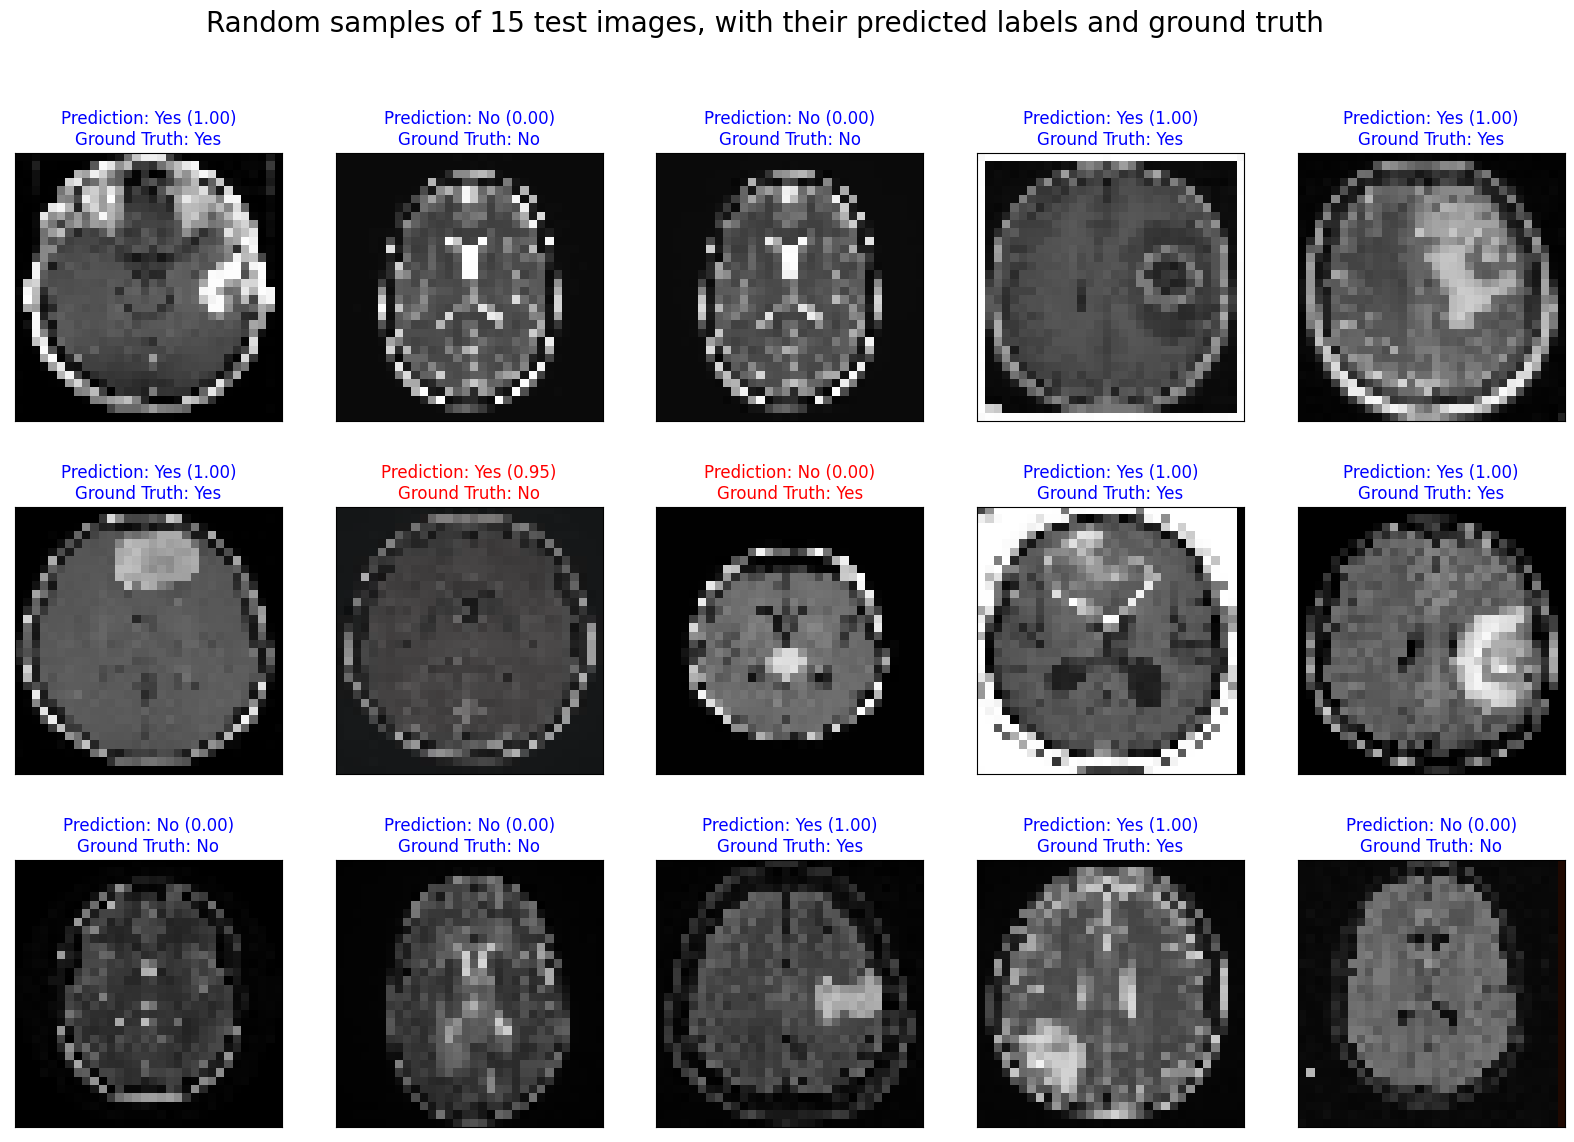

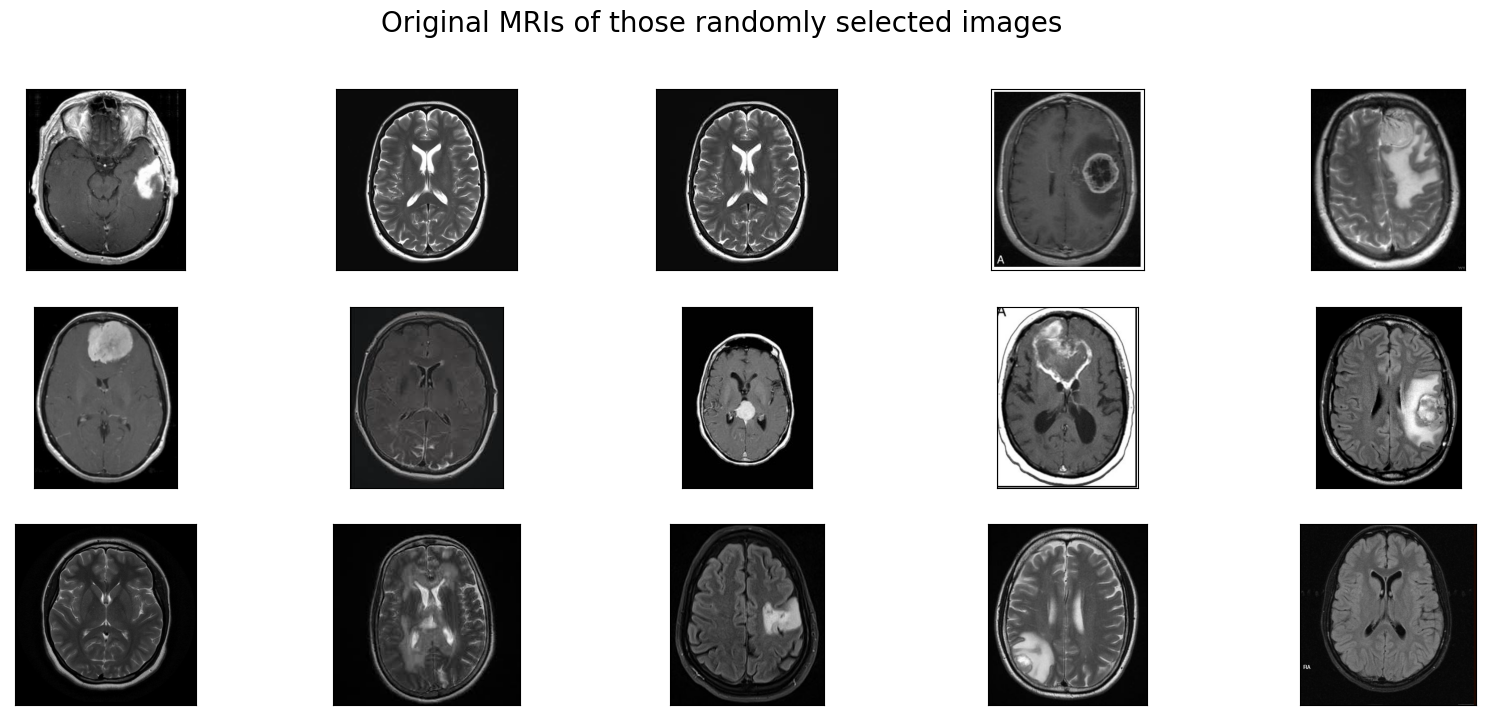

In [52]:
labels = ["No", "Yes"]
y_hat = model.predict(x_valid)
no_of_indices = 15
random_indices = np.random.choice(
    x_valid.shape[0], size=no_of_indices, replace=False)
# Plot a random sample of 15 test images, with their predicted labels and ground truth
figure = plt.figure(figsize=(20, 13))
sub_title = "Random samples of 15 test images, with their predicted labels and ground truth"
figure.suptitle(sub_title, fontsize=20)
for i in range(no_of_indices):
    rand_index = random_indices[i]

    # Display each image
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_valid[rand_index]))

    # Set the title for each image
    prediction_val = y_hat[rand_index][0]
    predict_index = 0 if (prediction_val < 0.5) else 1
    true_index = y_valid[rand_index]
    prediction = labels[predict_index]
    truth = labels[true_index]
    title_color = "blue" if predict_index == true_index else "red"
    ax_title = "Prediction: {} ({:.2f})\nGround Truth: {}".format(
        prediction, prediction_val, truth)
    ax.set_title(ax_title, color=title_color)
plt.show()

# Show the Original MRIs of the randomly selected images
figure = plt.figure(figsize=(20, 8))
figure.suptitle("Original MRIs of those randomly selected images", fontsize=20)
for i in range(no_of_indices):
    # get the original image
    img = x_orig_valid[random_indices[i]]
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(img))
plt.show()
